In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import json
import cv2
import h5py
import imageio
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")


2024-11-19 14:36:51.601188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 14:36:51.655197: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 14:36:51.656073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 14:36:52.552449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [66]:
## Preprocessing of image

In [2]:
# set home directory and data directory
HOME_DIR = "./NIfTI-files/"
DATA_DIR = HOME_DIR

In [3]:
image_nifty_file = DATA_DIR + "images_DSC/UPENN-GBM-00001_11/UPENN-GBM-00001_11_DSC.nii.gz"
image = np.array(nib.load(image_nifty_file).get_fdata())

In [4]:
image.shape

(240, 240, 155, 45)

In [5]:
label_nifty_file = DATA_DIR + "automated_segm/UPENN-GBM-00001_11_automated_approx_segm.nii.gz"
label = np.array(nib.load(label_nifty_file).get_fdata())

In [6]:
label.shape

(240, 240, 155)

In [7]:
print(np.unique(label))


[0. 1. 2. 4.]


In [22]:
# label = np.clip(label, 0, 3).astype(np.int32)
label[label > 0] = 1



In [23]:
print(np.unique(label))


[0 1]


In [24]:
is_categorical=False
if not is_categorical:
    label_cat = to_categorical(label, num_classes=4).astype(np.uint8)
label_cat.shape

(240, 240, 155, 4)

In [25]:
image_norm = cv2.normalize(image[:, :,:, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
image_norm.shape

(240, 240, 155)

In [26]:
labeled_image = np.zeros_like(label_cat[:, :, :, 1:])

# remove tumor part from image
labeled_image[:, :, :, 0] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 1] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 2] = image_norm * (label_cat[:, :, :, 0])

# color labels
labeled_image += label_cat[:, :, :, 1:] * 255

labeled_image.shape

(240, 240, 155, 3)

In [27]:
data_all = []
data_all.append(labeled_image)
np.array(data_all).shape

(1, 240, 240, 155, 3)

In [28]:
# coronal plane
coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
coronal = np.rot90(coronal, 1)
coronal.shape

(155, 240, 240, 3, 1)

In [29]:
# transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
transversal = np.rot90(transversal, 2)
transversal.shape

(240, 240, 155, 3, 1)

In [30]:
# sagittal plane
sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
sagittal = np.rot90(sagittal, 1)
sagittal.shape

(155, 240, 240, 3, 1)

In [32]:
def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        x = data_[min(i, data_.shape[0] - 1), :, :]
        y = data_[:, min(i, data_.shape[1] - 1), :]
        z = data_[:, :, min(i, data_.shape[2] - 1)]
        img = np.concatenate((x, y, z), axis=1)
        images.append(img)
    imageio.mimsave("./Binary_gif.gif", images, duration=0.01)
    return Image(filename="./Binary_gif.gif", format='png')

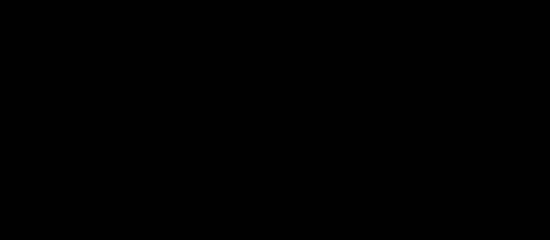

In [33]:
visualize_data_gif(labeled_image)

## Converting 3d to 2d Images

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Define input directories for structural images and segmentation masks
input_images_dir = "NIfTI-files/images_structural"  
input_segmentation_dir = "NIfTI-files/automated_segm"  

# Define output directories for 2D images and segmentation masks
output_images_dir = "/home/uca/Downloads/Image-Segmentation/2d_Dataset/Images"  
output_segmentation_dir = "/home/uca/Downloads/Image-Segmentation/2d_Dataset/atuo_segmentation"  

# Create the output directories if they don't exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_segmentation_dir, exist_ok=True)

# Loop through each folder in the input images directory
for folder in os.listdir(input_images_dir):
    folder_path = os.path.join(input_images_dir, folder)
    
    if os.path.isdir(folder_path):  # Ensure it's a folder
        # Loop through the files in the folder
        for file in os.listdir(folder_path):
            if "_FLAIR.nii.gz" in file:  
                image_file_path = os.path.join(folder_path, file)
                # Define the corresponding segmentation file path
                segmentation_file_path = os.path.join(input_segmentation_dir, f"{folder}_automated_approx_segm.nii.gz")
                
                # Check if the segmentation file exists
                if os.path.exists(segmentation_file_path):
                    print(f"Processing: {folder}")
                    
                    # Load the FLAIR image (3D)
                    flair_nii_image = nib.load(image_file_path)
                    flair_image_data = flair_nii_image.get_fdata()  
                    
                    # Normalize the FLAIR data for saving as an image (optional, based on pixel range)
                    flair_image_data = (flair_image_data - np.min(flair_image_data)) / (np.max(flair_image_data) - np.min(flair_image_data)) * 255
                    flair_image_data = flair_image_data.astype(np.uint8)
                    
                    # Loop through the slices (3rd dimension) and save FLAIR images as 2D PNG
                    for i in range(flair_image_data.shape[2]):
                        slice_2d = flair_image_data[:, :, i]  
                        
                        # Define the output filename for the FLAIR image
                        flair_output_filename = f"{folder}_Flair_Slice_{i + 1}.png"
                        flair_output_filepath = os.path.join(output_images_dir, flair_output_filename)
                        
                        # Save the FLAIR slice as a PNG image
                        plt.imsave(flair_output_filepath, slice_2d, cmap="gray")  # Save in grayscale

                    # Load the segmentation image (3D)
                    segmentation_nii_image = nib.load(segmentation_file_path)
                    segmentation_data = segmentation_nii_image.get_fdata()  # Extract segmentation data (3D array)
                    
                    # Convert segmentation to binary (0 and 1)
                    binary_segmentation = np.where(segmentation_data > 0, 1, 0)
                    
                    # Loop through the slices (3rd dimension) and save segmentation images as 2D PNG
                    for i in range(binary_segmentation.shape[2]):
                        segmentation_slice_2d = binary_segmentation[:, :, i]  # Extract the i-th slice
                        
                        # Define the output filename for the segmentation image
                        segmentation_output_filename = f"{folder}_Segmentation_Slice_{i + 1}.png"
                        segmentation_output_filepath = os.path.join(output_segmentation_dir, segmentation_output_filename)
                        
                        # Save the binary segmentation slice as a PNG image
                        plt.imsave(segmentation_output_filepath, segmentation_slice_2d, cmap="gray")  # Save in grayscale

print("Conversion complete! 2D slices saved in the following directories:")
print("Images:", output_images_dir)
print("Segmentations:", output_segmentation_dir)


Processing: UPENN-GBM-00530_11
Processing: UPENN-GBM-00061_11
Processing: UPENN-GBM-00433_11
Processing: UPENN-GBM-00126_11
Processing: UPENN-GBM-00458_11
Processing: UPENN-GBM-00039_11
Processing: UPENN-GBM-00067_11
Processing: UPENN-GBM-00323_11
Processing: UPENN-GBM-00397_11
Processing: UPENN-GBM-00537_11
Processing: UPENN-GBM-00380_11
Processing: UPENN-GBM-00074_11
Processing: UPENN-GBM-00343_11
Processing: UPENN-GBM-00288_11
Processing: UPENN-GBM-00596_11
Processing: UPENN-GBM-00251_11
Processing: UPENN-GBM-00379_11
Processing: UPENN-GBM-00498_11
Processing: UPENN-GBM-00166_11
Processing: UPENN-GBM-00304_11
Processing: UPENN-GBM-00527_11
Processing: UPENN-GBM-00529_11
Processing: UPENN-GBM-00150_11
Processing: UPENN-GBM-00546_11
Processing: UPENN-GBM-00299_11
Processing: UPENN-GBM-00116_11
Processing: UPENN-GBM-00170_11
Processing: UPENN-GBM-00595_11
Processing: UPENN-GBM-00366_11
Processing: UPENN-GBM-00319_11
Processing: UPENN-GBM-00094_11
Processing: UPENN-GBM-00395_11
Processi

Total number of FLAIR images created: 94705
Total number of segmentation images created: 94705


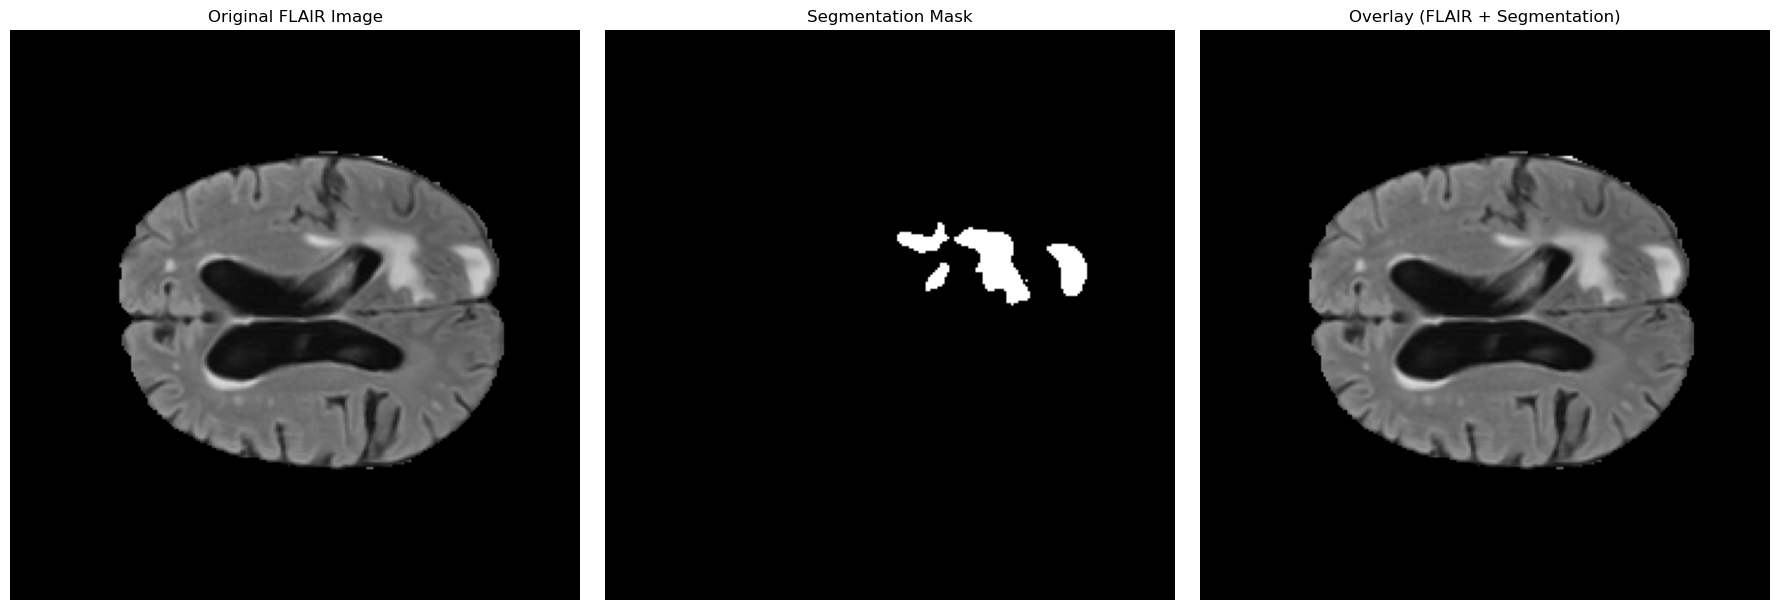

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the input directories for the 2D images and segmentations 
output_images_dir = "/home/uca/Downloads/Image-Segmentation/2d_Dataset/Images"
output_segmentation_dir = "/home/uca/Downloads/Image-Segmentation/2d_Dataset/atuo_segmentation"

# Count the total number of images in both directories
image_files = [f for f in os.listdir(output_images_dir) if f.endswith(".png")]
segmentation_files = [f for f in os.listdir(output_segmentation_dir) if f.endswith(".png")]

# Print the total count
print(f"Total number of FLAIR images created: {len(image_files)}")
print(f"Total number of segmentation images created: {len(segmentation_files)}")

# Visualize one random image and its corresponding segmentation mask with overlap
random_image_file = random.choice(image_files)  # Random image from the images folder
random_segmentation_file = random_image_file.replace("Flair", "Segmentation")  # Corresponding segmentation file

# Load the image and segmentation mask
image_path = os.path.join(output_images_dir, random_image_file)
segmentation_path = os.path.join(output_segmentation_dir, random_segmentation_file)

# Open the image and segmentation files
image = np.array(Image.open(image_path))  # FLAIR image
segmentation = np.array(Image.open(segmentation_path))  # Segmentation mask

# Create an overlay by combining the image and segmentation mask
# Here, we use the segmentation mask as a binary mask for the overlay
### This might not be the best approach so I have created another overlay visualization below
overlay = np.copy(image)  
overlay[segmentation == 1] = 255  

# Plot the original image, segmentation mask, and overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display the original image
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original FLAIR Image")
axes[0].axis("off")

# Display the segmentation mask
axes[1].imshow(segmentation, cmap="gray")
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")

# Display the image with the segmentation overlay
axes[2].imshow(overlay, cmap="inferno")
axes[2].set_title("Overlay (FLAIR + Segmentation)")
axes[2].axis("off")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
## Print the names of the selected image and its corresponding segmentation
print(f"Selected Image: {random_image_file}")
print(f"Corresponding Segmentation Image: {random_segmentation_file}")


Selected Image: UPENN-GBM-00181_11_Flair_Slice_80.png
Corresponding Segmentation Image: UPENN-GBM-00181_11_Segmentation_Slice_80.png


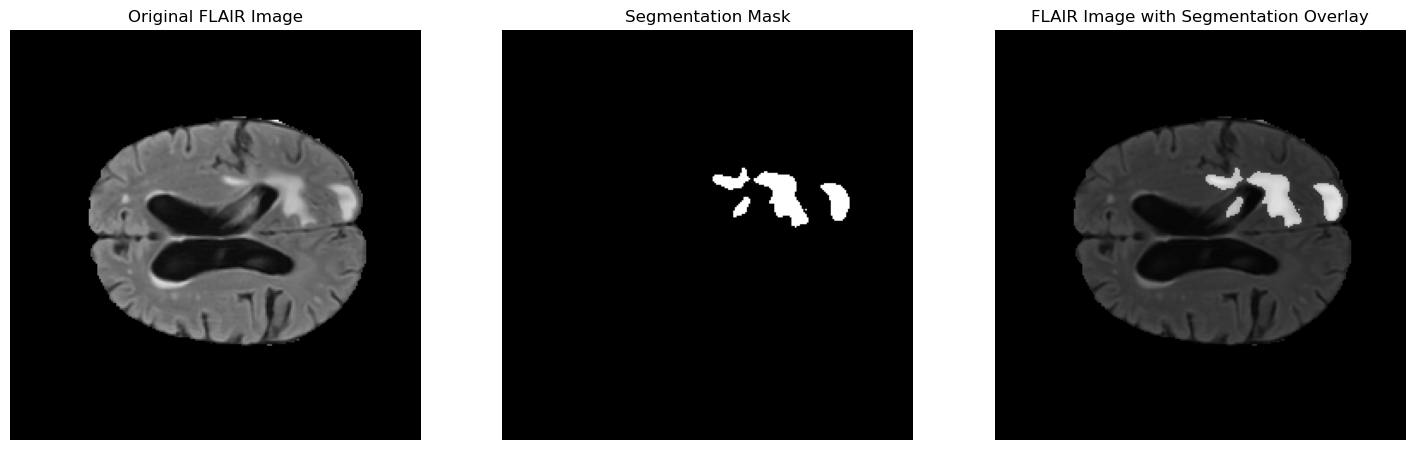

In [65]:
# Plot the original image, segmentation mask, and overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


# Display the original image
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original FLAIR Image")
axes[0].axis("off")

# Display the segmentation mask
axes[1].imshow(segmentation, cmap="gray")
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")


# Plot the original image
axes[2].imshow(image, cmap="inferno")
axes[2].imshow(segmentation, cmap="Reds", alpha=0.5)  
axes[2].set_title("FLAIR Image with Segmentation Overlay")

plt.axis("off")
plt.show()
